In [5]:
import cv2
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def vectorCrossProduct(v1, v2):
    line = np.array([
        v1[1]*v2[2] - v1[2]*v2[1],
        -(v1[0]*v2[2] - v1[2]*v2[0]),
        v1[0]*v2[1] - v1[1]*v2[0]
    ], dtype=np.float32)
    return line


def drawLine(img, p1, p2, color=(0, 255, 0)):
    cv2.line(
        img,
        (int(p1[0]/p1[2]), int(p1[1]/p1[2])),
        (int(p2[0]/p2[2]), int(p2[1]/p2[2])),
        color,
        1,
        cv2.LINE_AA
    )

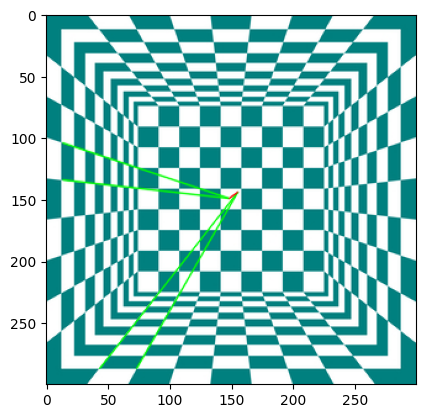

In [7]:
img_fp = r"/mnt/c/Users/SohaibWaheed/Desktop/Personal_Projects/Final_SuperPoint/300_BLC-Designs_teal_blue_white_checker_room.jpg"
img = plt.imread(img_fp).copy()
# To draw first pair of lines
line1_p1 = np.array([43, 287, 1])
line1_p2 = np.array([58, 268, 1])

line2_p1 = np.array([73, 287, 1])
line2_p2 = np.array([84, 268, 1])

line1 = vectorCrossProduct(line1_p1, line1_p2)
line1 /= line1[2]

line2 = vectorCrossProduct(line2_p1, line2_p2)
line2 /= line2[2]

intersectionPoint1 = vectorCrossProduct(line1, line2)
intersectionPoint1 = intersectionPoint1 / intersectionPoint1[2]


drawLine(img, line1_p1, intersectionPoint1)
drawLine(img, line2_p1, intersectionPoint1)


# To draw second pair of lines
line3_p1 = np.array([13, 104, 1])
line3_p2 = np.array([22, 107, 1])

line4_p1 = np.array([13, 134, 1])
line4_p2 = np.array([22, 135, 1])

line3 = vectorCrossProduct(line3_p1, line3_p2)
line3 /= line3[2]
line4 = vectorCrossProduct(line4_p1, line4_p2)
line4 /= line4[2]

intersectionPoint2 = vectorCrossProduct(line3, line4)
intersectionPoint2 = intersectionPoint2 / intersectionPoint2[2]

drawLine(img, line3_p1, intersectionPoint2)
drawLine(img, line4_p1, intersectionPoint2)


# Projection of the line at infinity
drawLine(img, intersectionPoint1, intersectionPoint2, color=(255, 0, 0))

plt.imshow(img)
plt.show()

In [8]:
Ha = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])


line_infinity = vectorCrossProduct(intersectionPoint1, intersectionPoint2)
line_infinity /= line_infinity[2]

unknown_H = np.array([
    [1, 0, 0],
    [0, 1, 0],
    line_infinity
])


H = Ha @ unknown_H

H_inverse = np.linalg.inv(H)

canonical_line_infinity = H_inverse.T @ line_infinity

In [9]:
# First transform corner points
height, width = img.shape[:2]

x_coords, y_coords = np.meshgrid(
    np.arange(width),
    np.arange(height)
)

original_points = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones(x_coords.ravel().shape[0])])
rectified_points = H @ original_points
rectified_points /= rectified_points[2]
rectified_points
x_min, y_min = rectified_points[0, :].min(), rectified_points[1, :].min()
x_max, y_max = rectified_points[0, :].max(), rectified_points[1, :].max()

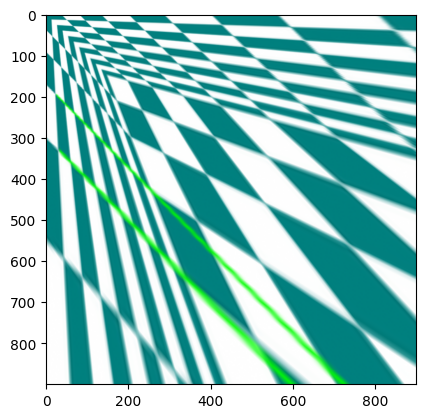

In [28]:
rectified_img = np.zeros(shape=(height*3, width*3, 3), dtype=img.dtype)
for x in range(width*3):
    for y in range(height*3):
        original_point = H_inverse @ np.array([[x], [y], [1]])
        original_point /= original_point[2]
        
        src_x, src_y = original_point[:2, 0]

        x0, y0 = int(src_x), int(src_y)
        x1, y1 = 1 + x0, 1 + y0
        
        top_left = img[y0, x0]
        top_right = img[y0, x1]
        bottom_left = img[y1, x0]
        bottom_right = img[y1, x1]
        
        
        pixel_value = (
            (x1 - src_x) * (y1 - src_y) * top_left  + \
            (src_x - x0) * (y1 - src_y) * top_right + \
            (x1 - src_x) * (src_y - y0) * bottom_left + \
            (src_x - x0) * (src_y - y0) * bottom_right    
        )
        rectified_img[y, x] = pixel_value
plt.imshow(rectified_img)
plt.show()

In [7]:
"""import cv2
import numpy as np
import matplotlib.pyplot as plt

def vectorCrossProduct(v1, v2):
    return np.array([
        v1[1]*v2[2] - v1[2]*v2[1],
        -(v1[0]*v2[2] - v1[2]*v2[0]),
        v1[0]*v2[1] - v1[1]*v2[0]
    ])

def drawLine(img, p1, p2, color=(0, 255, 0)):
    if p1[2] == 0 or p2[2] == 0:
        raise ValueError("Points must have non-zero homogeneous coordinates.")
    p1 = (int(p1[0] / p1[2]), int(p1[1] / p1[2]))
    p2 = (int(p2[0] / p2[2]), int(p2[1] / p2[2]))
    cv2.line(img, p1, p2, color, 1, cv2.LINE_AA)

# Load the image
img_fp = r"/mnt/c/Users/SohaibWaheed/Desktop/Personal_Projects/Final_SuperPoint/300_BLC-Designs_teal_blue_white_checker_room.jpg"
img = cv2.imread(img_fp)
if img is None:
    raise FileNotFoundError("Image not found at the given path.")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define first pair of lines
line1_p1 = np.array([43, 287, 1])
line1_p2 = np.array([58, 268, 1])
line2_p1 = np.array([73, 287, 1])
line2_p2 = np.array([84, 268, 1])

line1 = vectorCrossProduct(line1_p1, line1_p2)
line2 = vectorCrossProduct(line2_p1, line2_p2)
intersectionPoint1 = vectorCrossProduct(line1, line2)


# Define second pair of lines
line3_p1 = np.array([13, 104, 1])
line3_p2 = np.array([22, 107, 1])
line4_p1 = np.array([13, 134, 1])
line4_p2 = np.array([22, 135, 1])

line3 = vectorCrossProduct(line3_p1, line3_p2)
line4 = vectorCrossProduct(line4_p1, line4_p2)
intersectionPoint2 = vectorCrossProduct(line3, line4)


# Draw lines
drawLine(img, line1_p1, intersectionPoint1)
drawLine(img, line2_p1, intersectionPoint1)
drawLine(img, line3_p1, intersectionPoint2)
drawLine(img, line4_p1, intersectionPoint2)

# Draw line at infinity
drawLine(img, intersectionPoint1, intersectionPoint2, color=(255, 0, 0))

# Compute rectification transformation
line_infinity = vectorCrossProduct(intersectionPoint1, intersectionPoint2)
H = np.eye(3)
H[2] = line_infinity / line_infinity[2]

# Transform the image (optional)
rectified_img = cv2.warpPerspective(img, unknown_H, (img.shape[1], img.shape[0]))

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("Rectified Image")
plt.imshow(rectified_img)
plt.show()"""

'import cv2\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef vectorCrossProduct(v1, v2):\n    return np.array([\n        v1[1]*v2[2] - v1[2]*v2[1],\n        -(v1[0]*v2[2] - v1[2]*v2[0]),\n        v1[0]*v2[1] - v1[1]*v2[0]\n    ])\n\ndef drawLine(img, p1, p2, color=(0, 255, 0)):\n    if p1[2] == 0 or p2[2] == 0:\n        raise ValueError("Points must have non-zero homogeneous coordinates.")\n    p1 = (int(p1[0] / p1[2]), int(p1[1] / p1[2]))\n    p2 = (int(p2[0] / p2[2]), int(p2[1] / p2[2]))\n    cv2.line(img, p1, p2, color, 1, cv2.LINE_AA)\n\n# Load the image\nimg_fp = r"/mnt/c/Users/SohaibWaheed/Desktop/Personal_Projects/Final_SuperPoint/300_BLC-Designs_teal_blue_white_checker_room.jpg"\nimg = cv2.imread(img_fp)\nif img is None:\n    raise FileNotFoundError("Image not found at the given path.")\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n# Define first pair of lines\nline1_p1 = np.array([43, 287, 1])\nline1_p2 = np.array([58, 268, 1])\nline2_p1 = np.array([73, 287, 1])\nl

In [ ]:
import numpy as np

def warpPerspective(image, H, output_size):
    """
    Apply a perspective transformation to an image.

    Args:
        image (numpy.ndarray): Input image (H x W x C).
        H (numpy.ndarray): 3x3 perspective transformation matrix.
        output_size (tuple): Size of the output image (height, width).

    Returns:
        numpy.ndarray: Transformed output image.
    """
    # Invert the transformation matrix
    H_inv = np.linalg.inv(H)
    
    # Create an empty output image
    output_height, output_width = output_size
    output_image = np.zeros((output_height, output_width, image.shape[2]), dtype=image.dtype)
    
    for y in range(output_height):
        for x in range(output_width):
            # Transform the pixel coordinates using H_inv
            original_coords = np.array([x, y, 1], dtype=np.float64)
            transformed_coords = H_inv @ original_coords
            transformed_coords /= transformed_coords[2]  # Normalize
            
            # Get the original image coordinates
            src_x, src_y = transformed_coords[0], transformed_coords[1]
            
            # Check if the coordinates are within the bounds of the input image
            if 0 <= src_x < image.shape[1] and 0 <= src_y < image.shape[0]:
                # Bilinear interpolation
                x0, y0 = int(src_x), int(src_y)
                x1, y1 = min(x0 + 1, image.shape[1] - 1), min(y0 + 1, image.shape[0] - 1)
                dx, dy = src_x - x0, src_y - y0
                
                # Compute the pixel value
                top_left = image[y0, x0]
                top_right = image[y0, x1]
                bottom_left = image[y1, x0]
                bottom_right = image[y1, x1]
                
                
                pixel_value = (
                    (1 - dx) * (1 - dy) * top_left +
                    dx * (1 - dy) * top_right +
                    (1 - dx) * dy * bottom_left +
                    dx * dy * bottom_right
                )
                output_image[y, x] = pixel_value
    
    return output_image

# Example Usage
import cv2

# Load input image
input_image = img

# Define a transformation matrix H (e.g., obtained from cv2.getPerspectiveTransform)

# Specify the output image size (height, width)
output_size = (500, 500)

# Apply the custom warpPerspective function
output_image = warpPerspective(input_image, H, output_size)

# Save or display the result
cv2.imwrite('output.jpg', output_image)
cv2.imshow('Warped Image', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
